<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/finalV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade albumentations
!pip install torch-lr-finder
!git clone https://github.com/MittalNeha/vision_pytorch.git

     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 37.2MB 79kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'vision_pytorch'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 107 (delta 43), reused 40 (delta 12), pack-reused 0
Receiving objects: 100% (107/107), 34.11 KiB | 11.37 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip /content/tiny-imagenet-200.zip
print("Done")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

from vision_pytorch.dataloaders.tiny_image_net import *
from vision_pytorch.utils import datastats, lr_finder, plotting, dump_list
from vision_pytorch.models import resnet
from vision_pytorch.main import fit_model

In [ ]:
%cd /content/drive/MyDrive/EVA6/Session10/ass-A/session-10-assi

/content/drive/MyDrive/EVA6/Session10/ass-A/session-10-assi


In [ ]:
path = '/content/tiny-imagenet-200/'
X_train, X_test, y_train, y_test = get_data(path)

starting loading data
finished loading data, in 0.15152907371520996 seconds
Samples for training: 70000
Samples for testing: 30000


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print("CUDA Available:", use_cuda)
print("Selected Device:", device)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=256
else:
    BATCH_SIZE=32
print("Batch Size", BATCH_SIZE)

CUDA Available: True
Selected Device: cuda
Batch Size 256


In [ ]:
exp_data = ImagenetDataset(X_train, y_train)
exp = torch.utils.data.DataLoader(exp_data , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

mean, std = datastats.get_mean_std(exp)

The mean of dataset :  tensor([0.4803, 0.4482, 0.3976])
The std of dataset :  tensor([0.2766, 0.2691, 0.2819])


In [ ]:
id_to_class = exp_data.get_class_to_id_dict(path, get_id_dictionary(path))

In [ ]:
id_to_class[78]

('n02099601', 'golden retriever\n')

In [ ]:
id_to_class[141]

('n01774384', 'black widow, Latrodectus mactans\n')

In [ ]:
id_to_class[142]

('n02837789', 'bikini, two-piece\n')

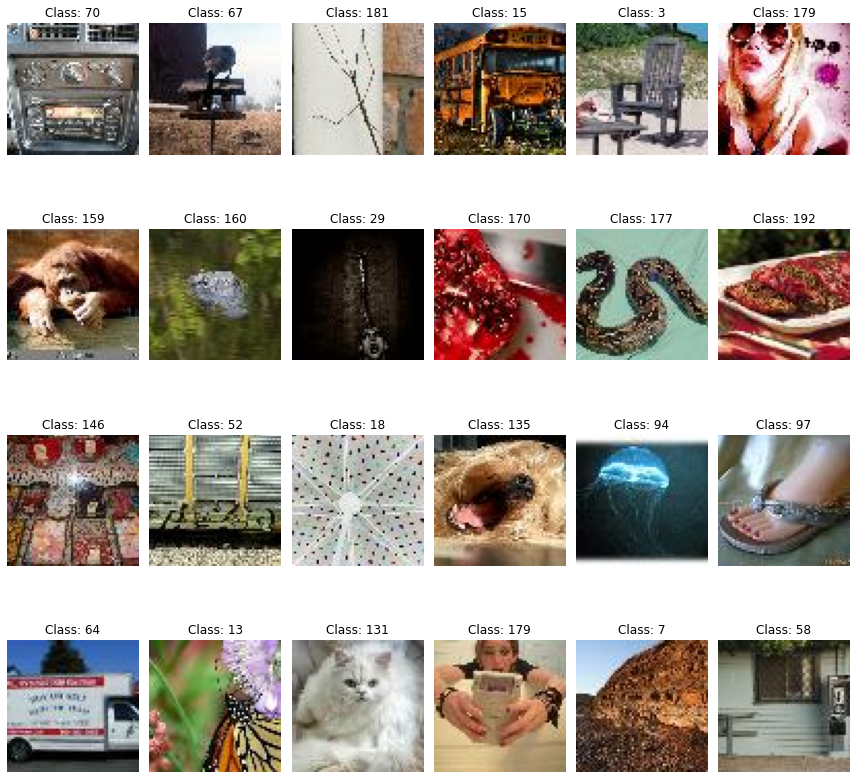

In [ ]:
plotting.plot_data(exp, 4, 6, 0, len(exp.dataset))

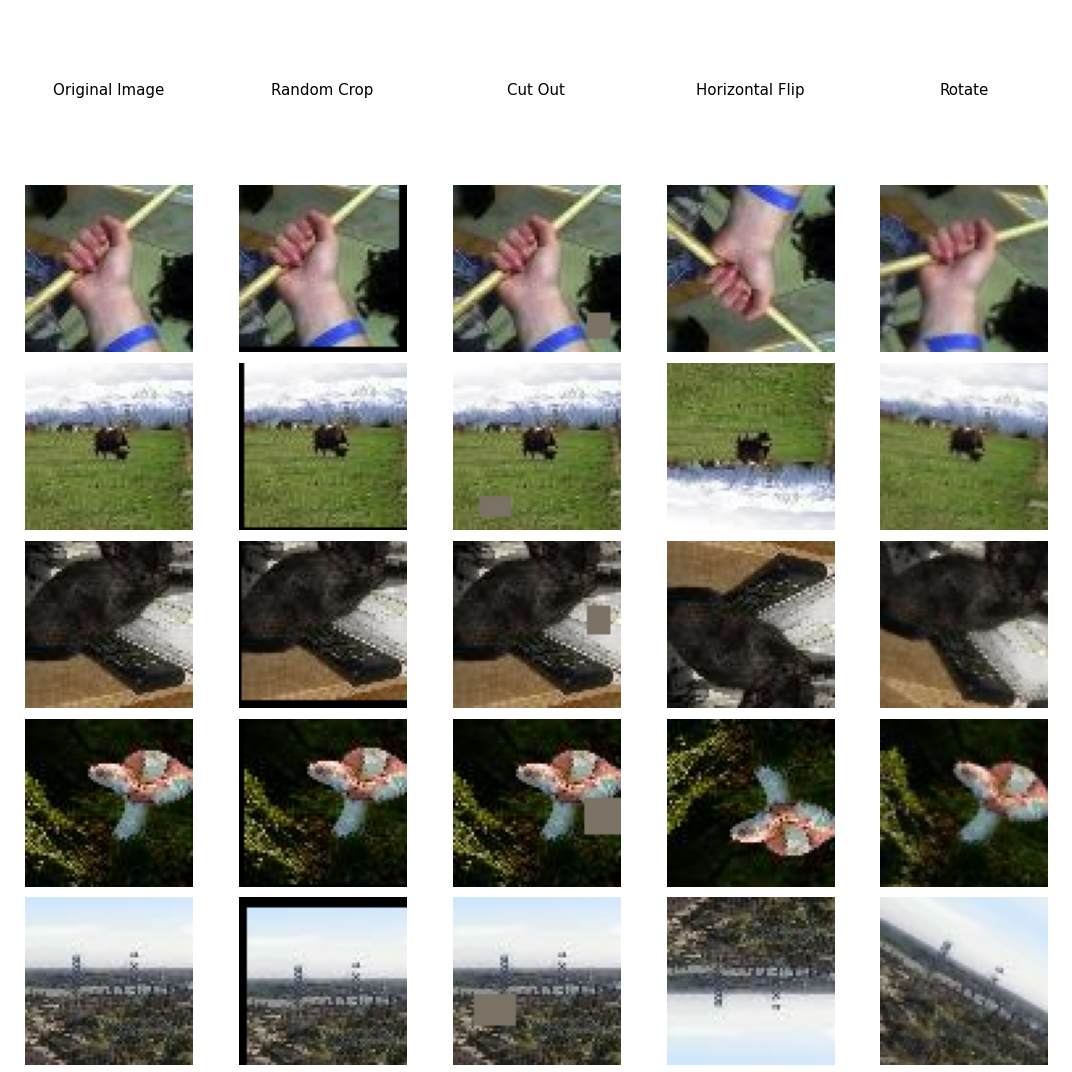

In [ ]:
plotting.plot_aug({
    'Original Image': None,
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                  A.RandomCrop(64,64)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, 
                               min_width=8, fill_value=mean*255., mask_fill_value=None, always_apply=True),
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Horizontal Flip': A.VerticalFlip(always_apply=True),
    'Rotate' :  A.Rotate(limit = 30, always_apply=True)
}, data=exp)

In [ ]:
train_transform = A.Compose([
  A.Normalize(mean, std),
  A.PadIfNeeded(min_height=72, min_width=72, always_apply=True),
  A.RandomCrop(64,64),
  A.Rotate(limit=15),
  A.CoarseDropout(1, 16, 16, 1, 8, 8,fill_value=mean*255., mask_fill_value=None),
  A.HorizontalFlip(),
  ToTensorV2()
])

test_transform = A.Compose([
  A.Normalize(mean, std),
  ToTensorV2()
])

train_loader = torch.utils.data.DataLoader(ImagenetDataset(X_train, y_train, train_transform) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ImagenetDataset(X_test, y_test, test_transform), batch_size=BATCH_SIZE,
                                           shuffle=False, num_workers=1)

In [ ]:
net = resnet.ResNet18(num_classes=200, dropout=0.025).to(device)
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.87E+00


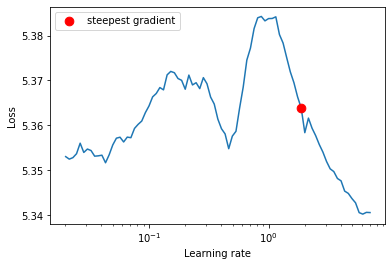

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
lr_finder.find_lr(net, optimizer, torch.nn.CrossEntropyLoss() ,train_loader)

# Training For Epoch 1 to 15

In [ ]:
epochs = 15
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(train_loader.dataset),
                                                epochs=epochs, div_factor=10, final_div_factor=10, 
                                                pct_start=10/epochs
                                              )
net, history, lr_trend = fit_model(
  net=net, device=device,
  train_loader=train_loader, test_loader=test_loader,
  optimizer=optimizer, 
  scheduler=scheduler,
  NUM_EPOCHS=epochs,
  save_best=True
)

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.0019999999999999983)


Batch_id=273 Loss=5.19366 Accuracy=1.26%: 100%|██████████| 274/274 [04:59<00:00,  1.09s/it]



Test set: Average loss: 4.9907, Accuracy: 802/30000 (2.67%)

Valid loss reduced from inf --> 4.990673.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 2 (LR: 0.002000006804848971)


Batch_id=273 Loss=4.82696 Accuracy=4.00%: 100%|██████████| 274/274 [05:02<00:00,  1.10s/it]



Test set: Average loss: 4.6811, Accuracy: 1730/30000 (5.77%)

Valid loss reduced from 4.99067 --> 4.681144.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 3 (LR: 0.0020000272193856014)


Batch_id=273 Loss=4.48417 Accuracy=7.72%: 100%|██████████| 274/274 [05:02<00:00,  1.11s/it]



Test set: Average loss: 4.3365, Accuracy: 2686/30000 (8.95%)

Valid loss reduced from 4.68114 --> 4.336451.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 4 (LR: 0.002000061243579012)


Batch_id=273 Loss=4.15038 Accuracy=11.89%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.9861, Accuracy: 4224/30000 (14.08%)

Valid loss reduced from 4.33645 --> 3.986078.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 5 (LR: 0.002000108877377761)


Batch_id=273 Loss=3.84154 Accuracy=16.00%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.7633, Accuracy: 4956/30000 (16.52%)

Valid loss reduced from 3.98608 --> 3.763331.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 6 (LR: 0.0020001701207098092)


Batch_id=273 Loss=3.61449 Accuracy=19.56%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.5080, Accuracy: 6298/30000 (20.99%)

Valid loss reduced from 3.76333 --> 3.507971.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 7 (LR: 0.0020002449734825498)


Batch_id=273 Loss=3.42866 Accuracy=22.64%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.4954, Accuracy: 6488/30000 (21.63%)

Valid loss reduced from 3.50797 --> 3.495427.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 8 (LR: 0.002000333435582785)


Batch_id=273 Loss=3.26906 Accuracy=25.37%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.3650, Accuracy: 7066/30000 (23.55%)

Valid loss reduced from 3.49543 --> 3.364959.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 9 (LR: 0.002000435506876754)


Batch_id=273 Loss=3.12407 Accuracy=27.82%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 3.0893, Accuracy: 8614/30000 (28.71%)

Valid loss reduced from 3.36496 --> 3.089294.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 10 (LR: 0.0020005511872101013)


Batch_id=273 Loss=2.99654 Accuracy=30.46%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 3.0640, Accuracy: 8772/30000 (29.24%)

Valid loss reduced from 3.08929 --> 3.063989.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 11 (LR: 0.0020006804764078935)


Batch_id=273 Loss=2.88054 Accuracy=32.57%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.8939, Accuracy: 9732/30000 (32.44%)

Valid loss reduced from 3.06399 --> 2.893936.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 12 (LR: 0.0020008233742746205)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.9458, Accuracy: 9428/30000 (31.43%)

Valid loss did not inprove
EPOCH: 13 (LR: 0.0020009798805941947)


Batch_id=273 Loss=2.67914 Accuracy=36.32%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.7871, Accuracy: 10375/30000 (34.58%)

Valid loss reduced from 2.89394 --> 2.787122.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 14 (LR: 0.002001149995129955)


Batch_id=273 Loss=2.58332 Accuracy=38.18%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.7125, Accuracy: 10789/30000 (35.96%)

Valid loss reduced from 2.78712 --> 2.712466.  Saving model to...model.pt


  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 15 (LR: 0.002001333717624648)


Batch_id=273 Loss=2.50363 Accuracy=39.78%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.6589, Accuracy: 11084/30000 (36.95%)

Valid loss reduced from 2.71247 --> 2.658908.  Saving model to...model.pt


In [ ]:
# saving learning info for plotting later
dump_list.dump_list_to_txt(history[0], 'training_acc.txt')
dump_list.dump_list_to_txt(history[1], 'training_loss.txt')
dump_list.dump_list_to_txt(history[2], 'testing_acc.txt')
dump_list.dump_list_to_txt(history[3], 'testing_loss.txt')
dump_list.dump_list_to_txt(lr_trend, 'lr_trend.txt')

# Training For Epoch 15 to 30

In [ ]:
net = resnet.ResNet18(num_classes=200, dropout=0.025).to(device)
net.load_state_dict(torch.load('model.pt')['state_dict'])

<All keys matched successfully>

In [ ]:
epochs = 15 # total 30
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(train_loader.dataset),
                                                epochs=epochs, div_factor=10, final_div_factor=10, 
                                                pct_start=10/epochs
                                              )
net, history, lr_trend = fit_model(
  net=net, device=device,
  train_loader=train_loader, test_loader=test_loader,
  optimizer=optimizer, 
  scheduler=scheduler,
  NUM_EPOCHS=epochs,
  save_best=True
)

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.0019999999999999983)


Batch_id=273 Loss=2.41930 Accuracy=41.47%: 100%|██████████| 274/274 [04:58<00:00,  1.09s/it]



Test set: Average loss: 2.5910, Accuracy: 11516/30000 (38.39%)
Valid loss reduced from inf --> 2.591004.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 2 (LR: 0.002000006804848971)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5984, Accuracy: 11511/30000 (38.37%)
Valid loss did not inprove
EPOCH: 3 (LR: 0.0020000272193856014)


Batch_id=273 Loss=2.27894 Accuracy=44.37%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.5238, Accuracy: 11938/30000 (39.79%)
Valid loss reduced from 2.59100 --> 2.523813.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 4 (LR: 0.002000061243579012)


Batch_id=273 Loss=2.20959 Accuracy=45.83%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.4708, Accuracy: 12376/30000 (41.25%)
Valid loss reduced from 2.52381 --> 2.470817.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 5 (LR: 0.002000108877377761)


Batch_id=273 Loss=2.14641 Accuracy=47.30%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.4183, Accuracy: 12675/30000 (42.25%)
Valid loss reduced from 2.47082 --> 2.418277.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 6 (LR: 0.0020001701207098092)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.5110, Accuracy: 12155/30000 (40.52%)
Valid loss did not inprove
EPOCH: 7 (LR: 0.0020002449734825498)


Batch_id=273 Loss=2.02322 Accuracy=49.74%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.3430, Accuracy: 13171/30000 (43.90%)
Valid loss reduced from 2.41828 --> 2.343022.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 8 (LR: 0.002000333435582785)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3500, Accuracy: 13127/30000 (43.76%)
Valid loss did not inprove
EPOCH: 9 (LR: 0.002000435506876754)


Batch_id=273 Loss=1.91328 Accuracy=52.20%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.2967, Accuracy: 13585/30000 (45.28%)
Valid loss reduced from 2.34302 --> 2.296711.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 10 (LR: 0.0020005511872101013)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3131, Accuracy: 13379/30000 (44.60%)
Valid loss did not inprove
EPOCH: 11 (LR: 0.0020006804764078935)


Batch_id=273 Loss=1.80684 Accuracy=54.70%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.2760, Accuracy: 13777/30000 (45.92%)
Valid loss reduced from 2.29671 --> 2.275964.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 12 (LR: 0.0020008233742746205)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.3398, Accuracy: 13358/30000 (44.53%)
Valid loss did not inprove
EPOCH: 13 (LR: 0.0020009798805941947)


Batch_id=273 Loss=1.71746 Accuracy=56.44%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.2287, Accuracy: 13897/30000 (46.32%)
Valid loss reduced from 2.27596 --> 2.228694.  Saving model to...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 14 (LR: 0.002001149995129955)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2433, Accuracy: 14066/30000 (46.89%)
Valid loss did not inprove
EPOCH: 15 (LR: 0.002001333717624648)


Batch_id=273 Loss=1.62581 Accuracy=58.30%: 100%|██████████| 274/274 [05:03<00:00,  1.11s/it]



Test set: Average loss: 2.2157, Accuracy: 14052/30000 (46.84%)
Valid loss reduced from 2.22869 --> 2.215708.  Saving model to...model.pt



In [ ]:
dump_list.dump_list_to_txt(history[0], 'training_acc.txt')
dump_list.dump_list_to_txt(history[1], 'training_loss.txt')
dump_list.dump_list_to_txt(history[2], 'testing_acc.txt')
dump_list.dump_list_to_txt(history[3], 'testing_loss.txt')
dump_list.dump_list_to_txt(lr_trend, 'lr_trend.txt')

# Training For Epoch 30 to 20

In [ ]:
net = resnet.ResNet18(num_classes=200, dropout=0.025).to(device)
net.load_state_dict(torch.load('model.pt')['state_dict'])

epochs = 20 # total 50
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(train_loader.dataset),
                                                epochs=epochs, div_factor=10, final_div_factor=10, 
                                                pct_start=10/epochs
                                              )
net, history, lr_trend = fit_model(
  net=net, device=device,
  train_loader=train_loader, test_loader=test_loader,
  optimizer=optimizer, 
  scheduler=scheduler,
  NUM_EPOCHS=epochs,
  save_best=True
)

dump_list.dump_list_to_txt(history[0], 'training_acc.txt')
dump_list.dump_list_to_txt(history[1], 'training_loss.txt')
dump_list.dump_list_to_txt(history[2], 'testing_acc.txt')
dump_list.dump_list_to_txt(history[3], 'testing_loss.txt')
dump_list.dump_list_to_txt(lr_trend, 'lr_trend.txt')

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.0019999999999999983)


Batch_id=273 Loss=1.54914 Accuracy=60.13%: 100%|██████████| 274/274 [05:02<00:00,  1.10s/it]



Test set: Average loss: 2.1770, Accuracy: 14353/30000 (47.84%)
Valid loss reduced from inf to 2.176970. checkpoint created at...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 2 (LR: 0.002000006804848971)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2204, Accuracy: 14176/30000 (47.25%)
Valid loss did not inprove from 2.17697

EPOCH: 3 (LR: 0.0020000272193856014)


Batch_id=273 Loss=1.46962 Accuracy=62.11%: 100%|██████████| 274/274 [05:05<00:00,  1.11s/it]



Test set: Average loss: 2.1762, Accuracy: 14362/30000 (47.87%)
Valid loss reduced from 2.17697 to 2.176218. checkpoint created at...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 4 (LR: 0.002000061243579012)


Batch_id=273 Loss=1.41993 Accuracy=63.25%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.1541, Accuracy: 14657/30000 (48.86%)
Valid loss reduced from 2.17622 to 2.154061. checkpoint created at...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 5 (LR: 0.002000108877377761)


Batch_id=273 Loss=1.37985 Accuracy=64.39%: 100%|██████████| 274/274 [05:04<00:00,  1.11s/it]



Test set: Average loss: 2.1312, Accuracy: 14686/30000 (48.95%)
Valid loss reduced from 2.15406 to 2.131203. checkpoint created at...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 6 (LR: 0.0020001701207098092)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1841, Accuracy: 14522/30000 (48.41%)
Valid loss did not inprove from 2.13120

EPOCH: 7 (LR: 0.0020002449734825498)


Batch_id=273 Loss=1.29572 Accuracy=66.28%: 100%|██████████| 274/274 [05:05<00:00,  1.11s/it]



Test set: Average loss: 2.1230, Accuracy: 14874/30000 (49.58%)
Valid loss reduced from 2.13120 to 2.123031. checkpoint created at...model.pt



  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 8 (LR: 0.002000333435582785)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1831, Accuracy: 14659/30000 (48.86%)
Valid loss did not inprove from 2.12303

EPOCH: 9 (LR: 0.002000435506876754)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1760, Accuracy: 14793/30000 (49.31%)
Valid loss did not inprove from 2.12303

EPOCH: 10 (LR: 0.0020005511872101013)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1846, Accuracy: 14588/30000 (48.63%)
Valid loss did not inprove from 2.12303

EPOCH: 11 (LR: 0.0020006804764078935)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1735, Accuracy: 14949/30000 (49.83%)
Valid loss did not inprove from 2.12303

EPOCH: 12 (LR: 0.0020008233742746205)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2778, Accuracy: 14434/30000 (48.11%)
Valid loss did not inprove from 2.12303

EPOCH: 13 (LR: 0.0020009798805941947)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2000, Accuracy: 14683/30000 (48.94%)
Valid loss did not inprove from 2.12303

EPOCH: 14 (LR: 0.002001149995129955)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2468, Accuracy: 14628/30000 (48.76%)
Valid loss did not inprove from 2.12303

EPOCH: 15 (LR: 0.002001333717624648)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1906, Accuracy: 14887/30000 (49.62%)
Valid loss did not inprove from 2.12303

EPOCH: 16 (LR: 0.0020015310478004554)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2368, Accuracy: 14813/30000 (49.38%)
Valid loss did not inprove from 2.12303

EPOCH: 17 (LR: 0.0020017419853589763)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.1870, Accuracy: 14977/30000 (49.92%)
Valid loss did not inprove from 2.12303

EPOCH: 18 (LR: 0.0020019665299812264)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2196, Accuracy: 14871/30000 (49.57%)
Valid loss did not inprove from 2.12303

EPOCH: 19 (LR: 0.002002204681327665)


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 2.2743, Accuracy: 14629/30000 (48.76%)
Valid loss did not inprove from 2.12303

EPOCH: 20 (LR: 0.0020024564390381527)


Batch_id=273 Loss=0.86949 Accuracy=76.71%: 100%|██████████| 274/274 [05:05<00:00,  1.11s/it]



Test set: Average loss: 2.2211, Accuracy: 15075/30000 (50.25%)
Valid loss did not inprove from 2.12303



In [ ]:
from vision_pytorch.main import save_model
save_model(net, 50, optimizer, 'model_50.pt')

# Learning Curves

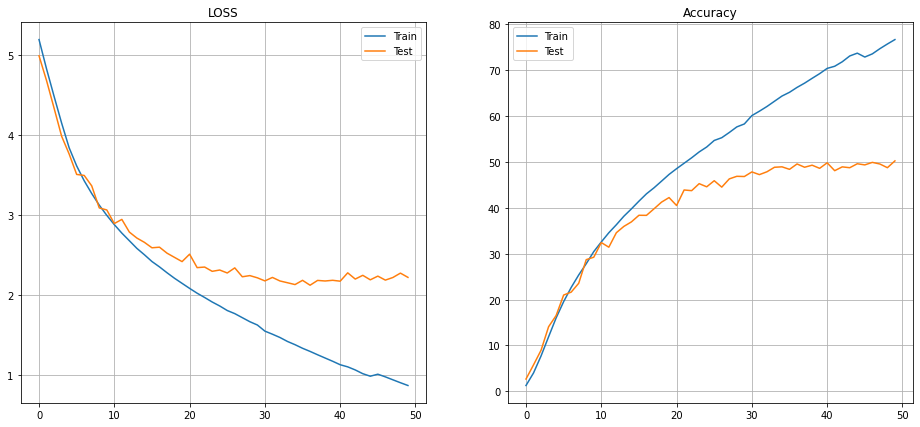

In [ ]:
plotting.plot_learning_curves(from_txt=['logs/training_acc.txt', 'logs/training_loss.txt', 'logs/testing_acc.txt', 'logs/testing_loss.txt'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

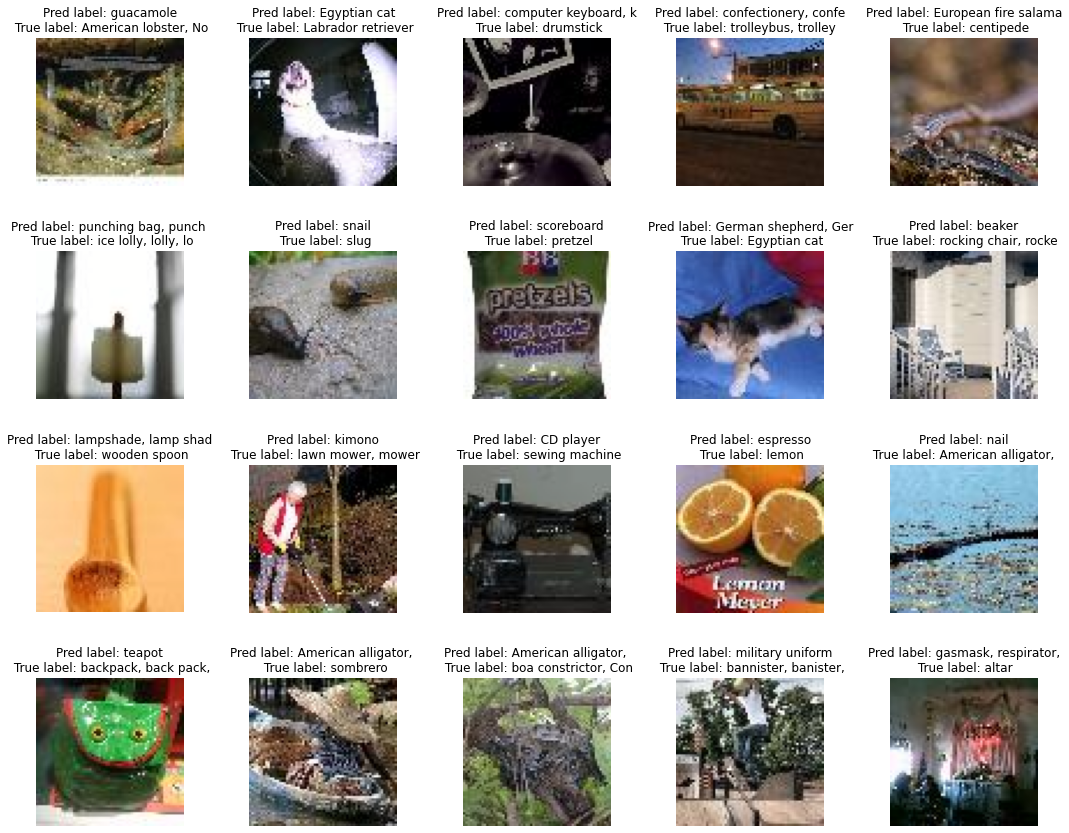

In [ ]:
plotting.plot_misclassified(net, test_loader, id_to_class_dict, device, mean, std)